<a href="https://colab.research.google.com/github/soorajpu12/LSTproject/blob/master/NDVIfromAWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center> Finding NDVI using Landsat-8 Geotiffs in Python </center>

# 1. Working with raster images

GDAL is a powerful and mature library for reading, writing and warping raster datasets, written in C++ with bindings to other languages. There are a variety of geospatial libraries available on the python package index, and almost all of them depend on GDAL. One such python library developed and supported by Mapbox-rasterio, builds on top of GDAL’s many features, but provides a more python-ic interface and supports many of the features and formats that GDAL supports.




In [19]:
pip install rasterio

In [20]:
pip install pyproj

In [0]:
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

**Using Landsat-8 images in Python**

The Landsat program is the longest-running civilian satellite imagery program, with the first satellite launched in 1972 by the US Geological Survey. Landsat 8 is the latest satellite in this program, and was launched in 2013. Landsat observations are processed into “scenes”, each of which is approximately 183 km x 170 km, with a spatial resolution of 30 meters and a temporal resolution of 16 days. The duration of the landsat program makes it an attractive source of medium-scale imagery for land surface change analyses.

**Satellite archives on the Cloud**

In [0]:
#print('Landsat on Google:')
#filepath = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B5.TIF'
#with rasterio.open(filepath) as src:
#    print(src.profile)

The context manager, rasterio.open() functions like the python standard library function open for opening files. The block of code within the with … as statement is executed once the file is opened, and the file is closed when the context manager exits. This means that we don’t have to manually close the raster file, as the context manager handles that for us.
Instead of a local file path, rasterio knows how to read URLs too, so we  pass the link to the file on AWS

src.profile is a collection of metadata for the file. We see that it is a Geotiff (Gtiff), the image values are unsigned integer format, nodata values are not assigned, the image has a dimensions of 7711x7531, is a single band, is in UTM coordinates, has a simple affine transformation, is chunked into smaller 512x512 arrays, tiled and compressed on the AWS hard drive where it is stored.

Note that we have not actually downloaded the image.We just read the metadata.

There is a subtle difference between the data on AWS and the data on Google. The image block sizes, or “tiling” is different, as is the compression scheme. It also turns out that AWS stores pre-made image overviews, but Google does not. It is important to realize that not all archives are the same. 

In [51]:
print('Landsat on AWS:')
filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/044/034/LC08_L1TP_044034_20191026_20191030_01_T1/LC08_L1TP_044034_20191026_20191030_01_T1_B4.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on AWS:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7671, 'height': 7811, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 463485.0,
       0.0, -30.0, 4264515.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


**Plot a low-resolution overview**

Overviews are reduced resolution versions of the dataset that can speed up rendering when you don’t need full resolution. By precomputing the upsampled pixels, rendering can be significantly faster when zoomed out. Overviews can be stored internally or externally, depending on the file format.

Decimation factor= 81
array type:  <class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Text(0, 0.5, 'Row #')

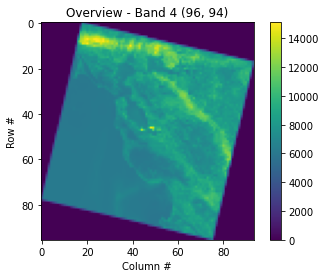

In [52]:
# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(filepath) as src:
   oviews = src.overviews(1) # list of overviews from biggest to smallest
   oview = oviews[-1] # let's look at the smallest thumbnail
   print('Decimation factor= {}'.format(oview))
   # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
   thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

print('array type: ',type(thumbnail))
print(thumbnail)

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

**Removing the background**

The pixels outside the imaged area are clearly set to “0”. Images commonly look like this because of satellite orbits and the fact that the Earth is rotating as imagery is acquired. The colormap is often improved if we change the out of bounds area to NaN. To do this we have to convert the datatype from uint16 to float32 (the array with NaNs will take 2x the storage space). The serrated edge is due to the coarse sampling of the full resolution image that we are doing here.

Decimation factor= 81


Text(0, 0.5, 'Row #')

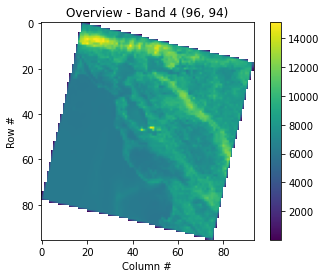

In [53]:
with rasterio.open(filepath) as src:
    oviews = src.overviews(1)
    oview = oviews[-1]
    print('Decimation factor= {}'.format(oview))
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

    thumbnail = thumbnail.astype('f4')
    thumbnail[thumbnail==0] = np.nan

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

**Request a subset of the image**

Text(0, 0.5, 'Row #')

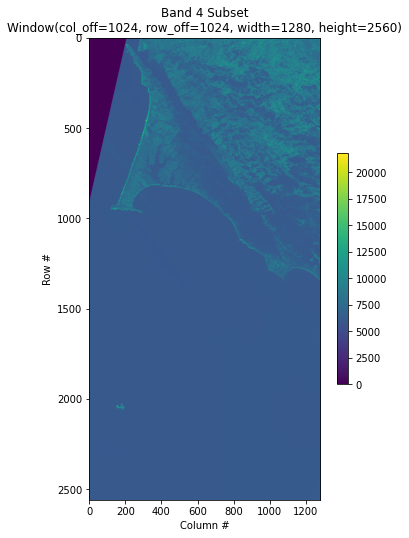

In [54]:
#https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
#rasterio.windows.Window(col_off, row_off, width, height)
window = rasterio.windows.Window(1024, 1024, 1280, 2560)

with rasterio.open(filepath) as src:
    subset = src.read(1, window=window)

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

# 2. Computation of NDVI

**Bands**

The Normalized Difference Vegetation Index is a simple indicator that can be used to assess whether the target includes healthy vegetation. This calculation uses two bands of a multispectral image dataset, the Red and Near-Infrared (NIR) bands:

Red: Band 4

Near-Infrared: Band 5

Because of the longevity of the landsat mission and because different sensors on the satellite record data at different resolutions, these bands are individually stored as single-band raster files. Some other rasters may store multiple bands in the same file.

In [0]:
# Use the same example image:
date = '2020-10-26'
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/044/034/LC08_L1TP_044034_20191026_20191030_01_T1/'
redband = 'LC08_L1TP_044034_20191026_20191030_01_T1_B{}.TIF'.format(4)
nirband = 'LC08_L1TP_044034_20191026_20191030_01_T1_B{}.TIF'.format(5)

Decimation factor= 9


Text(0, 0.5, 'Row #')

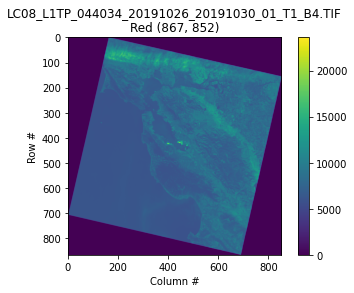

In [60]:
with rasterio.open(url+redband) as src:
    profile = src.profile
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(red)
plt.colorbar()
plt.title('{}\nRed {}'.format(redband, red.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Text(0, 0.5, 'Row #')

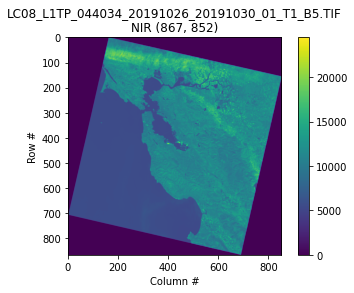

In [61]:
with rasterio.open(url+nirband) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(nir)
plt.colorbar()
plt.title('{}\nNIR {}'.format(nirband, nir.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0, 0.5, 'Row #')

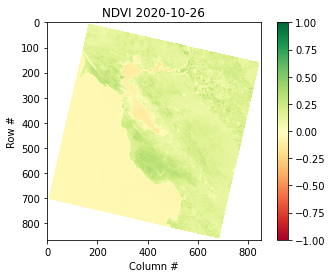

In [62]:
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

ndvi = calc_ndvi(nir,red)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

# 3. Save the NDVI raster to local disk

In [0]:
localname = 'LC08_L1TP_044034_20200403_20200410_01_T1_NDVI_OVIEW.tif'

with rasterio.open(url+nirband) as src:
    profile = src.profile.copy()

    aff = src.transform
    newaff = rasterio.Affine(aff.a * oview, aff.b, aff.c,
                             aff.d, aff.e * oview, aff.f)
    profile.update({
            'dtype': 'float32',
            'height': ndvi.shape[0],
            'width': ndvi.shape[1],
            'transform': newaff})  

    with rasterio.open(localname, 'w', **profile) as dst:
        dst.write_band(1, ndvi)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 852, 'height': 867, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(270.0, 0.0, 463485.0,
       0.0, -270.0, 4264515.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Text(0, 0.5, 'Row #')

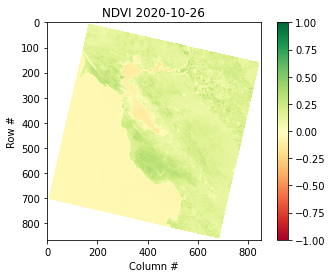

In [64]:
# Reopen the file and plot
with rasterio.open(localname) as src:
    print(src.profile)
    ndvi = src.read(1) # read the entire array

plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

Note that rasterio also has a ‘convenience method’ for plotting with georeferenced coordinates

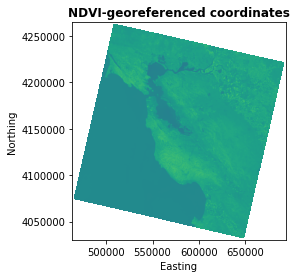

In [65]:
# in this case, coordinates are Easting [m] and Northing [m], and colorbar is default instead of RdYlGn
with rasterio.open(localname) as src:
    fig, ax = plt.subplots()    
    ax.ticklabel_format(useOffset=False, style='plain')
    rasterio.plot.show(src, ax=ax, title='NDVI-georeferenced coordinates')
    plt.xlabel('Easting')
    plt.ylabel('Northing')

Raster images really have two sets of coordinates. First, ‘image coordinates’ correspond to the row and column for a specific pixel. Second, the ‘spatial coordinates’ correspond to the location of each pixel on the surface of the Earth. Rasterio makes it convenient to use both coordinate systems.
Lets say you want the value of NDVI at a specific point in this scene. For example Fresno, CA (-119.770163586, 36.741997032). But the image is in UTM coordinates, so you have to first convert these points to UTM (Many websites will do this; https://www.geoplaner.com), or we can use the pyproj library. Be warned that this only works if you read the dataset at it’s full resolution (if you do decimated or windowed reads of the file, you need to adjust the affine transform).

In [66]:
with rasterio.open(localname) as src:
    # Use pyproj to convert point coordinates
    utm = pyproj.Proj(src.crs) # Pass CRS of image from rasterio
    lonlat = pyproj.Proj(init='epsg:4326')

    lon,lat = (-119.770163586, 36.741997032)
    east,north = pyproj.transform(lonlat, utm, lon, lat)

    print('Fresno NDVI\n-------')
    print(f'lon,lat=\t\t({lon:.2f},{lat:.2f})')
    print(f'easting,northing=\t({east:g},{north:g})')

    # What is the corresponding row and column in our image?
    row, col = src.index(east, north) # spatial --> image coordinates
    print(f'row,col=\t\t({row},{col})')

    # What is the NDVI?
    value = ndvi[row, col]
    print(f'ndvi=\t\t\t{value:.2f}')


    # Or if you see an interesting feature and want to know the spatial coordinates:
    row, col = 200, 450
    east, north = src.xy(row,col) # image --> spatial coordinates
    lon,lat = pyproj.transform(utm, lonlat, east, north)
    value = ndvi[row, col]
    print(f'''
Interesting Feature
-------
row,col=          ({row},{col})
easting,northing= ({east:g},{north:g})
lon,lat=          ({lon:.2f},{lat:.2f})
ndvi=              {value:.2f}
''')

Fresno NDVI
-------
lon,lat=		(-119.77,36.74)
easting,northing=	(788390,4.07112e+06)
row,col=		(716,1203)


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  import sys


IndexError: ignored

# 4. Change in NDVI over time

AWS Landsat-8 Archive page - https://registry.opendata.aws/landsat-8/

In [67]:
# Use the same example image:
date2 = '2020-10-10'
#url2 = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20180619_20180703_01_T1/'
url2 = 'http://landsat-pds.s3.amazonaws.com/c1/L8/044/034/LC08_L1TP_044034_20191010_20191018_01_T1/'
#redband2 = 'LC08_L1TP_042034_20180619_20180703_01_T1_B{}.TIF'.format(4)
#nirband2 = 'LC08_L1TP_042034_20180619_20180703_01_T1_B{}.TIF'.format(5)
redband2 = 'LC08_L1TP_044034_20191010_20191018_01_T1_B{}.TIF'.format(4)
nirband2 = 'LC08_L1TP_044034_20191010_20191018_01_T1_B{}.TIF'.format(5)

filepath = url2+redband2
with rasterio.open(filepath) as src:
    print('Opening:', filepath)
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red2 = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

filepath = url2+nirband2
with rasterio.open(filepath) as src:
    print('Opening:', filepath)
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    nir2 = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

ndvi2 = calc_ndvi(nir2, red2)

Opening: http://landsat-pds.s3.amazonaws.com/c1/L8/044/034/LC08_L1TP_044034_20191010_20191018_01_T1/LC08_L1TP_044034_20191010_20191018_01_T1_B4.TIF
Decimation factor= 9
Opening: http://landsat-pds.s3.amazonaws.com/c1/L8/044/034/LC08_L1TP_044034_20191010_20191018_01_T1/LC08_L1TP_044034_20191010_20191018_01_T1_B5.TIF
Decimation factor= 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0.5, 1.0, 'Diff (2020-10-10 - 2020-10-26)')

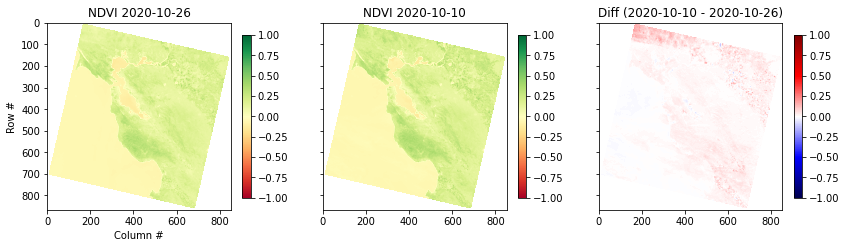

In [75]:
fig, axes = plt.subplots(1,3, figsize=(14,6), sharex=True, sharey=True)

plt.sca(axes[0])
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(shrink=0.5)
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.sca(axes[1])
plt.imshow(ndvi2, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(shrink=0.5)
plt.title('NDVI {}'.format(date2))

plt.sca(axes[2])
plt.imshow(ndvi2 - ndvi, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar(shrink=0.5)
plt.title('Diff ({} - {})'.format(date2, date))